# Correctly/Incorrectly Worn Face Mask Detection

## Setting up

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/

In [1]:
import sys
sys.path
sys.executable

'/Users/nguyen_l5/opt/anaconda3/envs/myenv/bin/python'

In [2]:
!which jupyter

/Users/nguyen_l5/opt/anaconda3/envs/myenv/bin/jupyter


In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import AveragePooling2D
from keras.models import Model, Sequential
from keras.layers import GlobalAveragePooling2D, Dropout, Dense, Activation, BatchNormalization, Conv2D, MaxPool2D, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import random
import os

In [4]:
print(keras.__version__)

2.7.0


In [5]:
print(tf.__version__)

2.7.0


In [10]:
IMAGE_SIZE = (300, 300) # resizing to reduce number of parameters
IMG_DIR = '/Users/nguyen_l5/Downloads/data'
BATCH_SIZE = 64 # small batch size to prevent Colab from crashing because of RAM shortage
NUM_CLASSES = 5

## Create dataset

In [30]:
dataset = []
for fold in os.listdir(IMG_DIR):
    if fold == 'incorrect':
        for filename in os.listdir(f'{IMG_DIR}/{fold}'):
            dataset.append((f'{fold}/{filename}', filename[11:].split('.')[0]))
    elif fold == 'maskoff':
        for filename in os.listdir(f'{IMG_DIR}/{fold}'):
            dataset.append((f'{fold}/{filename}', fold))
    else:
        for filename in os.listdir(f'{IMG_DIR}/{fold}'):
            dataset.append((f'{fold}/{filename}', fold))

df = pd.DataFrame(dataset, columns = ['filename', 'category'])
df_train, df_test = train_test_split(df, random_state = 123, stratify = df.category, test_size = 0.2)
df_train['set'] = 'train'
df_test['set'] = 'test'
df = df_train.append(df_test)
df.to_csv('/Users/nguyen_l5/Downloads/dataset.csv', index = False)
df.head()

/Users/nguyen_l5/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/nguyen_l5/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,filename,category,set
1864,incorrect/00132_Mask_Mouth_Chin.jpg,Mouth_Chin,train
1717,incorrect/05796_Mask_Chin.jpg,Chin,train
2346,incorrect/01601_Mask_Chin.jpg,Chin,train
590,correct/00603_Mask.jpg,correct,train
3062,incorrect/00475_Mask_Mouth_Chin.jpg,Mouth_Chin,train


In [31]:
# distribution of data among classes
df['category'].value_counts()

correct       950
Mouth_Chin    896
Chin          825
maskoff       708
Nose_Mouth    284
Name: category, dtype: int64

In [32]:
train_df = df[df['set'] == 'train'].reset_index(drop = True)
test_df = df[df['set'] == 'test'].reset_index(drop = True)

## Traditional Neural Network

In [33]:
# creating a data generator for both the train and test set that adds noise to data

training_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=5,
      horizontal_flip=True)

train_generator = training_datagen.flow_from_dataframe(
    train_df,
    IMG_DIR,
    x_col = 'filename',
    y_col = 'category',
    color_mode = 'rgb', # traditional rgb channels
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    seed = 123, # setting a seed to ensure consistency
    target_size = IMAGE_SIZE)

validation_datagen = ImageDataGenerator(
      rescale = 1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    test_df,
    IMG_DIR,
    x_col = 'filename',
    y_col = 'category',
    color_mode = 'rgb', # traditional rgb channels
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    target_size = IMAGE_SIZE,
    shuffle = False,
    seed = 123 # setting a seed to ensure consistency
    )

Found 2930 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.


In [34]:
# creating the network architecture

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape=IMAGE_SIZE+(3,)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (5,5), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (5,5), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax') # 5 because there are 5 classes
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 149, 149, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 145, 145, 64)      51264     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 72, 72, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 68, 68, 128)       204928    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 34, 34, 128)     

In [35]:
EPOCHS = 40
INIT_LR = 1e-4 # for the Adam optimizer

# compiling the model
model.compile(
    optimizer = keras.optimizers.Adam(
        learning_rate = INIT_LR, 
        decay = INIT_LR / EPOCHS),
    loss = keras.losses.categorical_crossentropy,
    metrics = ["accuracy"],
)

In [36]:
# fitting the model

CNN = model.fit(
    train_generator, 
    epochs = EPOCHS, 
    batch_size = BATCH_SIZE,
    validation_data = validation_generator,
    validation_batch_size = BATCH_SIZE,
)

Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
46/46 [==============================] - ETA: 0s - loss: 0.7765 - accuracy: 0.7276WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f85bacd37a0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and 

In [38]:
# saving the model
model.save('/Users/nguyen_l5/Downloads/model_weights_1112')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity t

2021-11-12 20:34:09.989066: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /Users/nguyen_l5/Downloads/model_weights_1112/assets


## Accuracy

In [39]:
new_model = tf.keras.models.load_model('/Users/nguyen_l5/Downloads/model_weights_1112')

In [40]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 149, 149, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 145, 145, 64)      51264     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 72, 72, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 68, 68, 128)       204928    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 34, 34, 128)     

In [41]:
test_labels = test_df['category'].to_list()

In [43]:
validation_classes = []
validation_images = []

for i in range( -(-validation_generator.samples // validation_generator.batch_size)):
    batch = validation_generator.next()
    expected = np.argmax(batch[1], axis = 1) 
    validation_classes.extend(expected)
    validation_images.extend(batch[0])

In [ ]:
validation_generator.samples

In [ ]:
validation_generator.next()

In [ ]:
test_classes = []
test_images = []

for i in range(len(test_df)):
    expected = np.argmax()

In [ ]:
from keras.preprocessing import image
pred_dir = '/Users/nguyen_l5/Downloads/test.jpg'
img = image.load_img(pred_dir, target_size=(300, 300))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

In [ ]:
print(new_model.predict(img_tensor).argmax(axis=-1))

In [44]:
# Evaluate the restored model
loss, acc = new_model.evaluate(test_df, test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(new_model.predict(test_df).shape)

ValueError: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, (<class 'list'> containing values of types {"<class 'str'>"})

acc:  [0.7276450395584106, 0.9634812474250793, 0.9843003153800964, 0.9863481521606445, 0.9846416115760803, 0.9894198179244995, 0.9921501874923706, 0.9904437065124512, 0.9952218532562256, 0.9945392608642578, 0.9959044456481934, 0.9962457418441772, 0.9979522228240967, 0.996928334236145, 0.9979522228240967, 0.9982935190200806, 0.9993174076080322, 1.0, 0.996928334236145, 0.9918088912963867, 0.9993174076080322, 0.9986348152160645, 0.9993174076080322, 0.9986348152160645, 1.0, 0.9996587038040161, 1.0, 0.9979522228240967, 0.9979522228240967, 0.9996587038040161, 0.9989761114120483, 0.9993174076080322, 1.0, 0.9993174076080322, 0.996928334236145, 0.9993174076080322, 0.9979522228240967, 0.9989761114120483, 1.0, 1.0]
val_acc:  [0.968622088432312, 0.9754433631896973, 0.9822646379470825, 0.9890859723091125, 0.9931787252426147, 0.9849931597709656, 0.9822646379470825, 0.9931787252426147, 0.9809004068374634, 0.9890859723091125, 0.9918144345283508, 0.9959072470664978, 0.9945429563522339, 0.99045020341873

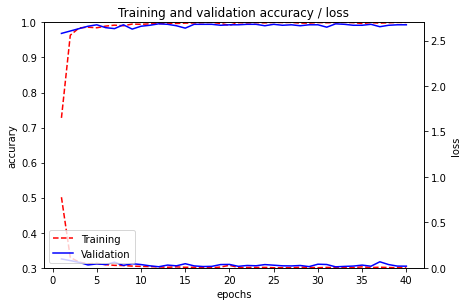

In [49]:
def show_accuracy(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc)+1)
  print("acc: ", acc)
  print("val_acc: ", val_acc)
  print("loss: ", loss)
  print("val_loss: ", val_loss)
  
  fig, ax1 = plt.subplots()
  fig.tight_layout()
  ax1.axis(ymin = 0.3, ymax = 1.0)
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('accurary')
  ax1.plot(epochs, acc, 'r--', label='Training accuracy')
  ax1.plot(epochs, val_acc, 'b', label='Validation accuracy')
  ax2 = ax1.twinx() 
  ax2.set_ylabel('loss')
  ax2.axis(ymin = 0.0, ymax = 2.7)
  ax2.plot(epochs, loss, 'r--', label='Training')
  ax2.plot(epochs, val_loss, 'b', label='Validation')
  plt.title('Training and validation accuracy / loss')
  plt.legend(loc="lower left")#"best")#0
  plt.show()

show_accuracy(CNN)

              precision    recall  f1-score   support

        CHIN       0.99      0.99      0.99       165
  MOUTH_CHIN       0.99      0.99      0.99       179
  NOSE_MOUTH       1.00      0.98      0.99        57
     CORRECT       0.99      1.00      1.00       190
     MASKOFF       0.99      0.99      0.99       142

    accuracy                           0.99       733
   macro avg       0.99      0.99      0.99       733
weighted avg       0.99      0.99      0.99       733



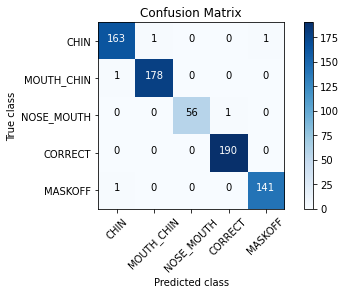

In [48]:
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools

def plot_confusion_matrix(cm, classes_map,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes_map))
    inv_map = {v: k for k, v in classes_map.items()}
    labels = inv_map.values()
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    if normalize:
        cm = np.around(cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis], 2)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True class')
    plt.xlabel('Predicted class')


validation_classes = []
validation_images = []

for i in range( -(-validation_generator.samples // validation_generator.batch_size)):
   batch = validation_generator.next()
   expected = np.argmax(batch[1], axis = 1) 
   validation_classes.extend(expected)
   validation_images.extend(batch[0])

validation_classes = np.array(validation_classes)
validation_images = np.array(validation_images)

Y_pred = model.predict(validation_images)
y_pred = np.argmax(Y_pred, axis=1)


print(classification_report(validation_classes, y_pred,
                            target_names = ['CHIN', 'MOUTH_CHIN', 'NOSE_MOUTH', 'CORRECT', 'MASKOFF']))

cfs_mt = confusion_matrix(validation_classes, y_pred)
classes = {'CHIN': 0, 'MOUTH_CHIN': 1, 'NOSE_MOUTH': 2, 'CORRECT': 3, 'MASKOFF': 4}
plot_confusion_matrix(cfs_mt, classes_map = classes)

In [54]:
np.argmax(validation_generator.next()[1], axis =1)

array([0, 3, 4, 3, 0, 3, 4, 2, 3, 4, 1, 0, 0, 0, 4, 0, 4, 1, 1, 4, 3, 4,
       4, 3, 1, 3, 2, 4, 1, 0, 1, 3, 1, 1, 1, 1, 2, 0, 2, 0, 0, 1, 1, 0,
       1, 3, 0, 0, 2, 3, 2, 0, 1, 2, 2, 0, 1, 4, 4, 4, 1, 4, 0, 1])

In [55]:
test_df['category'].value_counts()

correct       190
Mouth_Chin    179
Chin          165
maskoff       142
Nose_Mouth     57
Name: category, dtype: int64